In [1]:
from HARK.rewards import CRRAutility, CRRAutilityP
from HARK.utilities import construct_assets_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType, init_lifecycle, init_idiosyncratic_shocks
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
from HARK.stage import Stage, backwards_induction
import cons_stages

R = cons_stages.R # 1.01
G = cons_stages.G # 1.02

CRRA = cons_stages.CRRA
epsilon = cons_stages.epsilon
sigma_psi = cons_stages.sigma_psi # 1.05
sigma_theta = cons_stages.sigma_theta #1.15
#sigma_eta = 1.1
p_live = 0.98
DiscFac = .96

In [4]:
def display_stage(stage):
    print(f"x: {stage.inputs}, k: {stage.shocks}, a: {stage.actions}, y: {stage.outputs}")

In [5]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')

## Consumption with Independent Shocks

_Notebook by Sebastian Benthall_

In this notebook, we will use both HARK and BARK to build and solve a household consumption model with independent shocks, and compare the results.

### Simple Model

In [6]:
cycles = 10
init_simple = init_idiosyncratic_shocks.copy()
init_simple['cycles'] = cycles

In [7]:
init_simple.update({
    'CRRA' : CRRA,
    'Rfree' : R,
    'DiscFac' : DiscFac,
    'LivPrb' : [p_live],
    'PermGroFac' : [G],
    'PermShkStd' : [sigma_psi],
    'TranShkStd' : [sigma_theta],
    'UnempPrb': 0.00,
})

### With HARK

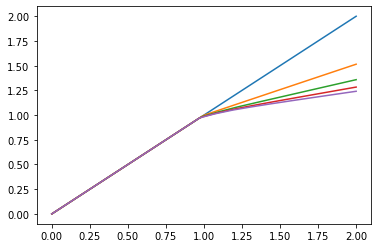

In [8]:
agent = IndShockConsumerType(**init_simple)
agent.solve()

fig = plt.figure()

x = np.linspace(0,2, 100)
N = 5

for t in range(cycles, cycles - N, -1):
    plt.plot(x, agent.solution[t].cFunc(x))
    
plt.show()

In [33]:
agent

<HARK.ConsumptionSaving.ConsIndShockModel.IndShockConsumerType object at 0x7faae5276a70.
Parameters:
cycles: 10
CRRA: 2.0
Rfree: 1.03
DiscFac: 0.96
LivPrb: [0.98]
PermGroFac: [1.01]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 10000
aNrmInitMean: 0.0
aNrmInitStd: 1.0
pLvlInitMean: 0.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: None
T_cycle: 1
PerfMITShk: False
aXtraMin: 0.001
aXtraMax: 20
aXtraNestFac: 3
aXtraCount: 48
aXtraExtra: [None]
PermShkStd: [0.1]
PermShkCount: 7
TranShkStd: [0.1]
TranShkCount: 7
UnempPrb: 0.0
UnempPrbRet: 0.005
IncUnemp: 0.3
IncUnempRet: 0.0
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
neutral_measure: False
NewbornTransShk: False>

### With BARK

We have predefined some stage definitions in this module:

The labor stage has no actions. In this stage, the agent experiences exogenous shocks and grows their resources.

In [9]:
c_stage = cons_stages.consumption_stage
l_stage = cons_stages.labor_stage
r_stage = cons_stages.rfree_stage

display_stage(l_stage)

x: ['b'], k: {'theta': <HARK.distribution.Lognormal object at 0x7faae5471390>, 'psi': <HARK.distribution.Lognormal object at 0x7faae5471ab0>}, a: [], y: ['m']


#### Consumption stage

In [10]:
display_stage(c_stage)

x: ['m'], k: {}, a: ['c'], y: ['a']


The consumption stage models the transition $a = m - c$ where $c$ is the choice of consumption. It has no shocks.

We will straightforwardly solve the consumption stage/block using EGM.

#### Returns stage

In [11]:
display_stage(r_stage)

x: ['a'], k: {}, a: [], y: ['b']


We can repeat these stages again and again to simulate the household earning and consuming over time.

But there's one small problem: the output of the consumption stage is $m$ while the input of the labor stage is $b$.

We need to transform $m$ to $b$.

#### Labor stage

In [12]:
display_stage(l_stage)

x: ['b'], k: {'theta': <HARK.distribution.Lognormal object at 0x7faae5471390>, 'psi': <HARK.distribution.Lognormal object at 0x7faae5471ab0>}, a: [], y: ['m']


The general form of the marginal value update for a b-block is:

$$v'_x(x) = \mathbb{E}_k\left[\frac{\partial q}{\partial x}(x, k, \pi^*(x, k)) \right] = \mathbb{E}_k\left[\beta v'_y(T(x, k, \pi^*(x, k)))\frac{\partial T}{\partial x} (x, k, \pi^*(x, k) \right]$$

In the case of the labor stage:

- $g(b, \theta, \psi) = \frac{b + \theta}{G \psi}$
  - $\frac{\partial g}{\partial b} = \frac{1}{G \psi}$
- $\beta(\theta, \psi) = (G \psi) ^ {\rho -1}$ -- disputed

Therefore:

$$v'_x(b) = \mathbb{E}_{\psi, \theta} \left[(G\psi)^{\rho - 1} v'_y \left( \frac{b + \theta}{G \psi} \right) \frac{1}{G\psi} \right]$$

In [13]:
l_stage.shocks['theta'].discretize(7).atoms.min()

0.8546929589435168

#### Setting up the problem

In [14]:
l_v_y_der_terminal = lambda y : CRRAutilityP(y['m'], CRRA) if y['m'] >= 0 else float('inf')

In [36]:
x_space = np.append([-l_stage.shocks['theta'].discretize(7).atoms.min(),0],
                    construct_assets_grid(agent))

stages_data = [
    {
        'stage' : c_stage,
        'y_grid' : {'a' : x_space},
        'optimizer_args' :{
            'a0f' : lambda x: x['m'] - epsilon
        },
        'method' : 'egm'
    },
    {
        'stage' : r_stage,
        'x_grid' : {'a' : x_space},
    },
    {
        'stage' : l_stage,
        'x_grid' : {
            'b' : x_space #* R
        },
        'shock_approx_params' : {
            'psi' : 7, 
            'theta' : 7, 
        }
    },
    #tick
]

In [37]:
c_v_y_der_terminal = lambda y : CRRAutilityP(y['a'], CRRA)

In [38]:
#sols = backwards_induction(stages_data, x_space, terminal_v_y_der = l_v_y_der_terminal)

# Failing on second expectation ...
sols = backwards_induction(stages_data * 2, x_space, terminal_v_y_der = l_v_y_der_terminal)

5: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
solve: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
No actions for this stage. Skipping to value backup.
None
Time to backwards induce v_x: 0:00:13.324958
<xarray.Dataset>
Dimensions:  (b: 50)
Coordinates:
  * b        (b) float64 -0.8547 0.0 0.001 0.02017 ... 11.83 13.97 16.64 20.0
Data variables:
    v_x_der  (b) float64 inf 1.019 1.017 0.9787 ... 0.004534 0.003255 0.002074
4: X: ['a'], K: [], A: [], Y: ['b']
solve: X: ['a'], K: [], A: [], Y: ['b']
No actions for this stage. Skipping to value backup.
None
Time to backwards induce v_x: 0:00:00.198826
<xarray.Dataset>
Dimensions:  (a: 50)
Coordinates:
  * a        (a) float64 -0.8547 0.0 0.001 0.02017 ... 11.83 13.97 16.64 20.0
Data variables:
    v_x_der  (a) float64 1.143e+03 1.029 1.027 ... 0.004328 0.003053 0.001951
3: X: ['m'], K: [], A: ['c'], Y: ['a']
solve: X: ['m'], K: [], A: ['c'], Y: ['a']
pi_star.coords: Coordinates:
  * m        (m) float64 -0.8245 0.0 1.006 1.008 ... 25.

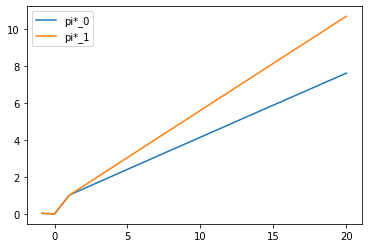

In [39]:
import matplotlib.pyplot as plt

for i, s in enumerate([sols[i] for i in (range(0,len(sols), 3))]):
    plt.plot(x_space[:50], [s.pi_star({'m' : m,}, {})['c'] for m in x_space[:50]], label = f"pi*_{i}")
    
plt.legend()

### Combined plot

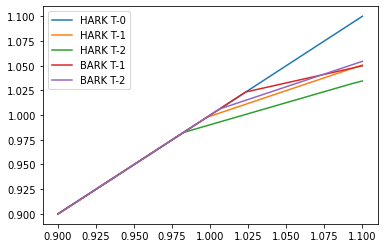

In [40]:
agent = IndShockConsumerType(**init_simple)
agent.solve()

fig = plt.figure()

x = np.linspace(0.9,1.1, 200)
N = 3

for t in range(cycles, cycles - N, -1):
    plt.plot(x, agent.solution[t].cFunc(x), label = f"HARK T-{10 - t}")
    
for i, s in enumerate([sols[i] for i in (range(0,len(sols), 3))]):
    plt.plot(x, [s.pi_star({'m' : m,}, {})['c'] for m in x], label = f"BARK T-{i+1}")

plt.legend()
plt.show()

**Problems**

* BARK at T - 1 is still slightly off of HARK at T - 1
  * (Marginal) value function transformation slightly off? (This doesn't seem to change the numbers)

Plotting the difference:

Plotted difference in the consumption functions

0.3821048698644016


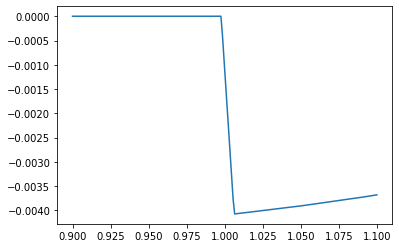

In [41]:
bark_cfunc = np.array([sols[3].pi_star({'m' : m,}, {})['c'] for m in x])

plt.plot(x, agent.solution[9].cFunc(x) - bark_cfunc)

print(np.abs(agent.solution[9].cFunc(x) - bark_cfunc).sum())

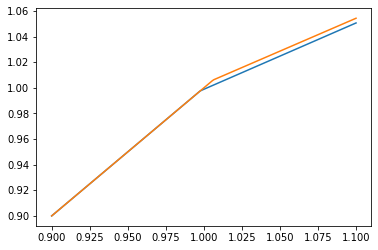

In [42]:
plt.plot(x, agent.solution[9].cFunc(x))
plt.plot(x, bark_cfunc)

1.9010819276902085


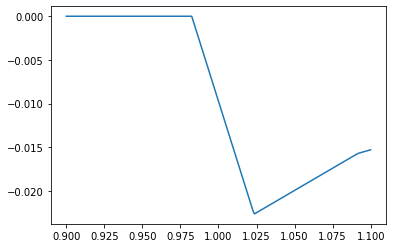

In [43]:
bark_cfunc = np.array([sols[0].pi_star({'m' : m,}, {})['c'] for m in x])

plt.plot(x, agent.solution[8].cFunc(x) - bark_cfunc)

print(np.abs(agent.solution[8].cFunc(x) - bark_cfunc).sum())

Plotted differences in the _marginal_ value functions a $T - 1$.

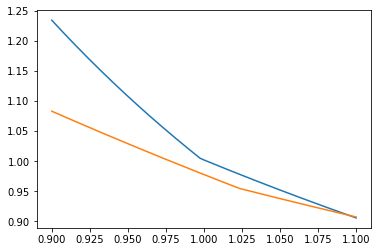

In [44]:
plt.plot(x, agent.solution[9].vPfunc(x))


bark_vPfunc = sols[0].v_x_der({'m' : x,})# np.array([sols[0].v_x_der({'m' : m,}) for m in x])
plt.plot(x, bark_vPfunc)

**TODO: Pick a better marginal value interpolation transform** 

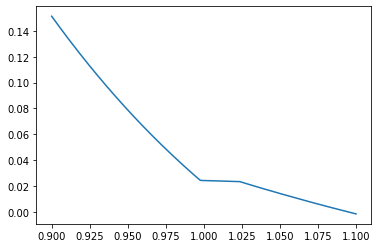

In [45]:
plt.plot(x, agent.solution[9].vPfunc(x) - bark_vPfunc)

In [46]:
sols[2]

<xarray.Dataset>
Dimensions:  (b: 50)
Coordinates:
  * b        (b) float64 -0.8547 0.0 0.001 0.02017 ... 11.83 13.97 16.64 20.0
Data variables:
    v_x_der  (b) float64 inf 0.9854 0.9844 0.9658 ... 0.0152 0.01118 0.008038

In [26]:
sols[0]

<xarray.Dataset>
Dimensions:  (m: 51)
Coordinates:
  * m        (m) float64 -0.8547 0.0 1.023 1.025 ... 19.15 22.42 26.5 31.64
Data variables:
    v_x_der  (m) float64 inf inf 0.9548 0.9539 ... 0.01399 0.01027 0.007375
    pi*      (m) float64 0.0 0.0 1.023 1.024 1.034 ... 7.321 8.455 9.866 11.64

In [27]:
sols[0].v_x_der({'m':0.5}, pdb = True)

<xarray.DataArray 'v_x_der' ()>
array(1.67109511)
Coordinates:
    m        float64 0.5

In [28]:
x_space

array([-8.54692959e-01,  0.00000000e+00,  1.00000000e-03,  2.01713727e-02,
        4.04645973e-02,  6.19689346e-02,  8.47826891e-02,  1.09014323e-01,
        1.34783729e-01,  1.62223697e-01,  1.91481594e-01,  2.22721307e-01,
        2.56125489e-01,  2.91898165e-01,  3.30267760e-01,  3.71490637e-01,
        4.15855231e-01,  4.63686907e-01,  5.15353678e-01,  5.71272965e-01,
        6.31919613e-01,  6.97835428e-01,  7.69640582e-01,  8.48047286e-01,
        9.33876256e-01,  1.02807664e+00,  1.13175022e+00,  1.24618095e+00,
        1.37287121e+00,  1.51358644e+00,  1.67041051e+00,  1.84581461e+00,
        2.04274370e+00,  2.26472534e+00,  2.51600777e+00,  2.80173618e+00,
        3.12817922e+00,  3.50302228e+00,  3.93574988e+00,  4.43814835e+00,
        5.02497206e+00,  5.71483401e+00,  6.53140746e+00,  7.50506263e+00,
        8.67511887e+00,  1.00929770e+01,  1.18265253e+01,  1.39664114e+01,
        1.66350835e+01,  2.00000000e+01])

#### old material

We used to use a twist stage but then replaced it with rfree_stage, because of investing and probability of death.

In [29]:
from HARK.stage import Stage, backwards_induction

### TWIST STAGE

def twist(mapper):
    return Stage(
        transition = lambda x, k, a : {mapper[xi] : x[xi] for xi in mapper}, 
        transition_der_x = 1,
        inputs = list(mapper.keys()), 
        actions = [],
        outputs = list(mapper.values())
    )
    
      
twist_stage = twist({'a' : 'b'})

**What's a better marginal value function transform?**

----

    v_transform = np.exp, # lambda c: CRRAutility_inv(c, CRRA),
    v_transform_inv = np.log, # lambda c : CRRAutility_inv(c, CRRA),
    v_der_transform = lambda u: u ** -1 , #  CRRAutilityP_inv
    v_der_transform_inv = lambda u : u ** -1, # u ** - rho
    
----

$\mathbf{v}$ ranges from ${-\infty, 0}$
    
    
$v_i(x) = f^{-1}I(f(\mathbf{v}), x)$

Options:

$f(x) = e^x$

$f(x) = u^{-1}(x)$

-----

$\mathbf{v'}$ ranges from ${0, \infty}$

$v'_i(x) = g^{-1}I(g(\mathbf{v'}), x)$

$g(x) = x^{-1}$

$g(x) = e^{-x}$